## Preprocessing

In [1]:
import pandas as pd
import random
from cvxpy import *
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, block_diag, bmat
timeseries = pd.read_csv("insilico_size10_1_timeseries.tsv", sep='\t', header=0)
perturbations  = pd.read_csv("insilico_size10_1_timeseries_perturbations.tsv", sep='\t', header=0)

#the first column of timeseries is time, each experiment 21 rows
timeseries = np.array(timeseries)
perturbations = np.array(perturbations)

In [2]:
dif_time = np.unique(timeseries[:,0])[1] - np.unique(timeseries[:,0])[0]
M = np.unique(timeseries[:,0]).shape[0]
p = timeseries.shape[0]/M

trunc = 0.15
p1, p2 = 100, 200

In [3]:
timeseries = timeseries[:,1:]
n = timeseries.shape[1]

In [4]:
nonzeros = perturbations != 0
zeros = 1 - nonzeros

In [5]:
rand_zeros = np.zeros((p,n))
for i in range(zeros.shape[0]):
    for j in range(zeros.shape[1]):
        if zeros[i,j] != 0:
            rand_zeros[i,j] = np.random.random_sample()

In [6]:
def deriv(N = M, timeseries = timeseries):
    h = 1. / dif_time
    data = np.array([np.ones(N) * (-2), np.ones(N), np.ones(N)])
    B = scipy.sparse.spdiags(data, np.array([0, -1, 1]), N, N)
    B *= h ** 2
    D = block_diag([B] * p)
    x = timeseries.copy()
    y = D.dot(x)
    return y.reshape(M * p * n, 1)

In [7]:
def Phi_b(i, j, timeseries = timeseries):
    Fb_self = timeseries[i * M + j, :]
    Fb_connect = Fb_self / (1 + Fb_self) 
    Fb = np.hstack((Fb_self, Fb_connect))
    Fb = np.hstack((Fb, Fb_connect))
    I = np.eye(n)
    Phi_b = np.kron(Fb, I)
    return Phi_b

In [8]:
def matrix_Phi(timeseries = timeseries):
    phis = []
    for i in range(p):
        for j in range(M):
            phis.append(Phi_b(i, j))    
    result = block_diag(phis)
    return result

In [9]:
import networkx as nx

def draw_graph(d, nedges):
    means = np.mean(d, axis = 1).reshape(-1)
    sums = np.abs(np.sum(np.abs(d) < 1e-8, axis = 1))
    sums = np.argsort(np.abs(means).flatten())
    n = sums.shape[1]
    
    graph = []
    for i in range(1, nedges):
        graph.append({'from' : sums[0,n - i] / 30,
                      'to' : sums[0,n - i] % 10,
                      'value' : means[0,sums[0,n - i]]})
        
    G = nx.MultiDiGraph()

    for i in range(1, 10 + 1):
        G.add_node(i)
        G.node[i]['name'] = 'G' + str(i)

    for i in graph:
        G.add_weighted_edges_from([(i['from'] + 1,
                                    i['to'] + 1,
                                    100 * i['value'])])
        
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw(G, with_labels = True, edge_color=weights, arrows = True, edge_cmap=plt.cm.RdBu_r)
    plt.show()

In [10]:
Y = deriv()
Phi = matrix_Phi()
u_init = (np.hstack([rand_zeros] * M)).reshape(M * n * p, 1)

## Methods

### 1. lsqr

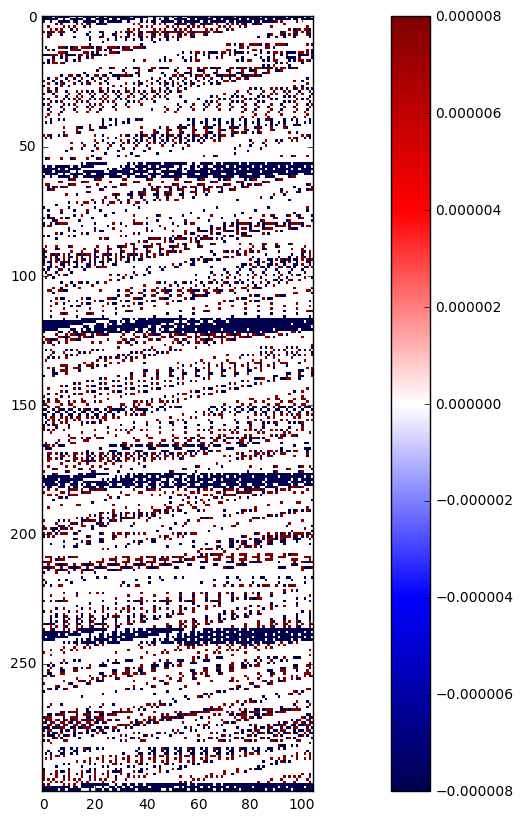

In [11]:
#leastsquares
s = scipy.sparse.linalg.lsqr(Phi, Y)[0]
s = s.reshape(3*n**2,M*p)
d=np.round(s,5)
vmin = max(-d.min(), d.max())/10.
plt.figure(figsize=(20, 10))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.colorbar()
plt.show()

# has wrong scale

In [12]:
TVc = 0
for i in range(2,M*p):
    TVc += np.linalg.norm((s[:,i] - s[:,i-1]),1)
print TVc, np.linalg.norm(s,1)

0.163515956875 0.00189546430392


### 2. Pseudoinverse

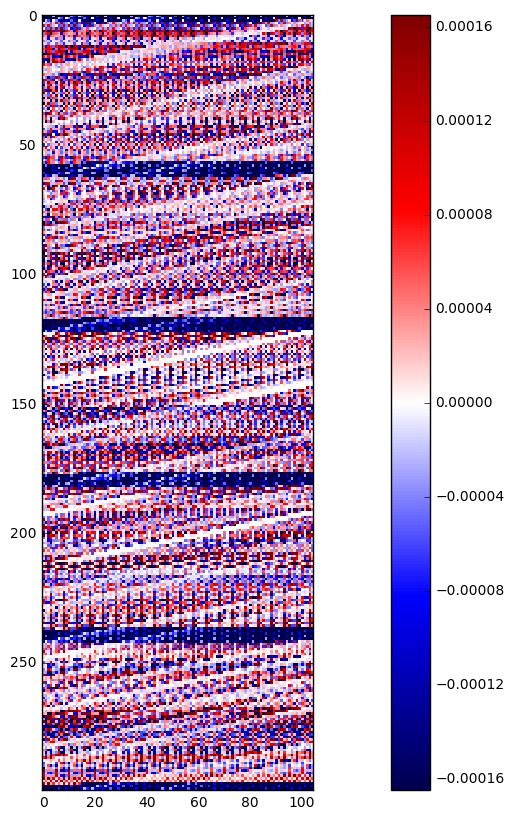

In [13]:
#pseudoinverse
Ah_1 = np.linalg.pinv(Phi.toarray()) 
s2 = Ah_1.dot(Y)
s2 = 20*s2.reshape(3*n**2,M*p)
d=np.round(s2,5)
vmin = max(-d.min(), d.max())/10.
plt.figure(figsize=(20, 10))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.colorbar()
plt.show()

In [14]:
TVc = 0
for i in range(2,M*p):
    TVc += np.linalg.norm((s2[:,i] - s2[:,i-1]),1)
print TVc, np.linalg.norm(s2,1)

3.27031911612 0.0379092858663


### 3. Without constraints

In [15]:
Q = Variable(3*n**2,M*p)
lam1 = 0.017
lam_TV = 1.
lam_constr = .7
TV = 0
for i in range(2,M*p):
    TV += norm((Q[:,i] - Q[:,i-1]),1)
constr = (norm((mul_elemwise(u_init,deriv()) - 
                mul_elemwise(u_init,matrix_Phi()*reshape(Q.T,3*n**2*M*p,1))),1))
obj = Minimize(lam_TV*TV + lam1 * norm(Q, 1) + lam_constr*constr)
constraints = []

prob = Problem(obj, constraints)
prob.solve()  

0.010111047314751563

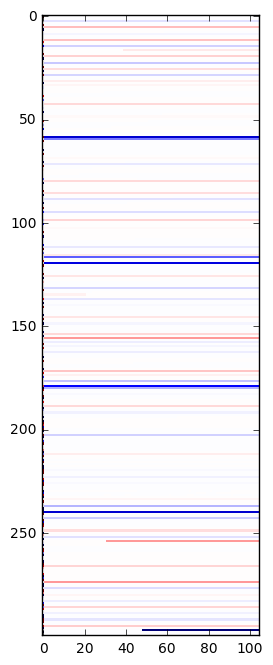

In [16]:
d=Q.value
vmin = max(-d.min(), d.max())/15.
plt.figure(figsize=(5, 8))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.show()

In [17]:
TVc = 0
for i in range(2,M*p):
    TVc += np.linalg.norm((Q.value[:,i] - Q.value[:,i-1]),1)
print TVc, np.linalg.norm(Q.value,1)

8.46432083485e-05 0.0191416360652


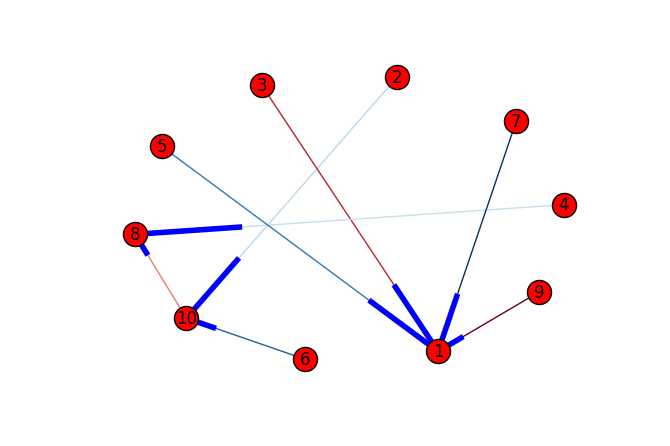

In [18]:
draw_graph(d, 10)

### 4. Basic CVX

In [19]:
Q = Variable(3*n**2,M*p)
lam1 = 0.017
lam_TV = 1.

TV = 0
for i in range(2,M*p):
    TV += norm((Q[:,i] - Q[:,i-1]),1)

obj = Minimize(lam_TV*TV + lam1 * norm(Q, 1))
constraints = [mul_elemwise(u_init,Y) == mul_elemwise(u_init,Phi*reshape(Q.T,3*n**2*M*p,1))]

prob = Problem(obj, constraints)
prob.solve()  

0.04971625674763161

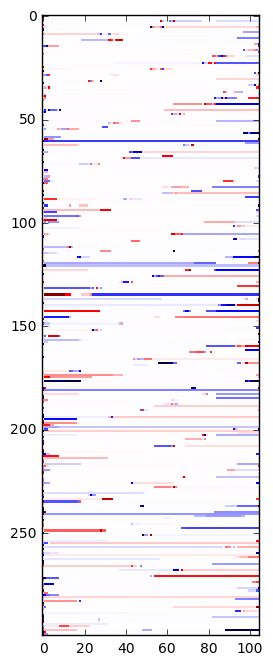

In [20]:
d=Q.value
vmin = max(-d.min(), d.max())/50.
plt.figure(figsize=(5, 8))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.show()

In [21]:
TVc = 0
for i in range(2,M*p):
    TVc += np.linalg.norm((Q.value[:,i] - Q.value[:,i-1]),1)
print TVc, np.linalg.norm(Q.value,1)

0.0460285049185 0.0265260375938


### 5. 3 points TV

In [22]:
Q = Variable(3*n**2,M*p)
lam1 = 0.005
lam_TV = 1.2
lam_constr = 1.1
TV = norm((Q[:,1] - 2*Q[:,0]),1)
for i in range(2,M*p-1):
    TV += norm((Q[:,i+1] - 2*Q[:,i] + Q[:,i-1]),1)
    
TV += norm((Q[:,M*p-2] - 2*Q[:,M*p-1]),1) 
    
constr = (norm((mul_elemwise(u_init,deriv()) - 
                    mul_elemwise(u_init,matrix_Phi()*reshape(Q.T,3*n**2*M*p,1))),1))
obj = Minimize(lam_TV*TV + lam1 * norm(Q, 1) + lam_constr*constr)

constraints =[]

In [23]:
prob = Problem(obj, constraints)
prob.solve()  

0.015150931180286254

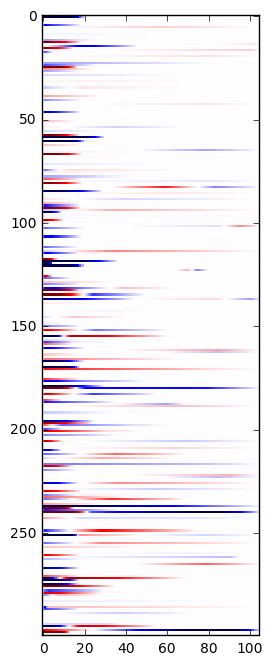

In [24]:
d=Q.value
vmin = max(-d.min(), d.max())/5.
plt.figure(figsize=(5, 8))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.show()

In [25]:
TVc = 0
for i in range(2,M*p):
    TVc += np.linalg.norm((Q.value[:,i] - Q.value[:,i-1]),1)
print TVc, np.linalg.norm(Q.value,1)

0.0225598094156 0.0171980232502


### 6. LADM

In [26]:
# scalar shrinkage operator
# returns sgn(x) max(|x| - eps, 0)
def ScalarShrinkage(x, eps):
    x[np.abs(x) < eps] = 0.0
    return x

# returns U ScalarShrinkage(sigma, eps) V^T
def S(x, eps):
    U, s, V = np.linalg.svd(x, full_matrices = False)
    return (U.dot(np.diag(ScalarShrinkage(s, eps)))).dot(V.T)

# updates values from omega
def P(x, omega):
    r = np.zeros_like(x)
    for i, j in omega:
        r[i, j] = x[i, j]
    return r

# computes supp
def supp(E, eps = 1e-4):
    return set(map(tuple, np.column_stack((np.where(np.abs(E) > eps)))))

In [27]:
def compute_ADM(B1, W, D, E, l, alpha, omega, N_ITERS = 3, nu1 = 3, nu2 = 3, p = 2.7):
    def update_A(Ak, Wk, Ek, Y1k, Y2k, uk, l):
        m = Wk - Y1k / uk
        m = m.reshape((300, 105))

        return S(m, 1 / uk).reshape((31500, 1))
    
    def update_W(Ak, Wk, Ek, Y1k, Y2k, uk, l):
        PWk = P(B1.dot(W) + Ek - D + Y2k / uk, omega)
        x = Wk - ((B1.T.dot(PWk)) + Wk - Ak - Y1k / uk) / nu1
        return ScalarShrinkage(x, l / (uk * nu1))
    
    def update_E(Ak, Wk, Ek, Y1k, Y2k, uk, l):
        PEk = P(E + (B1.dot(Wk)) - D, omega)
        x = Ek - (PEk  + Y2k / uk) / nu2
        return ScalarShrinkage(x, alpha / (uk * nu2))
    
    def update_Y2(Ak, Wk, Ek, Y1k, Y2k, uk, l):        
        return Y2k + uk * P((B1.dot(Wk)) + Ek - D, omega)
    
    def update_Y1(Ak, Wk, Ek, Y1k, Y2k, uk, l):
        return Y1k + uk * (Ak - Wk)
    
    Ak = B1.T.dot(D)
    Wk = Ak.copy()
    Ek = np.zeros(E.shape)
    Y1k = np.zeros(W.shape)
    Y2k = np.zeros(D.shape)
    uk = 0.1
    
    for i in range(N_ITERS):
        Ak = update_A(Ak, Wk, Ek, Y1k, Y2k, uk, l)
#        print "a", Ak.mean()
        Wk = update_W(Ak, Wk, Ek, Y1k, Y2k, uk, l)
        Ek = update_E(Ak, Wk, Ek, Y1k, Y2k, uk, l)   
        Y1k = update_Y1(Ak, Wk, Ek, Y1k, Y2k, uk, l)
        Y2k = update_Y2(Ak, Wk, Ek, Y1k, Y2k, uk, l)
        uk *= p
        
    return Wk, Ek

In [28]:
def comute_nuclear_opt(B1, D, l, alpha, N_ITERS = 10):
    a, b = B1.shape
    Wk = np.zeros((b, 1))
    Ek = 100 * np.random.rand(*D.shape)
    
    E = np.zeros(D.shape)
    x, y = np.indices(E.shape)
    x = x.flatten()
    y = y.flatten()
    omega_k = set(map(tuple, np.column_stack((x, y))))
    for i in range(N_ITERS):
        Wk, Ek = compute_ADM(B1, Wk, D, Ek, l, alpha, omega_k)
        
        omega_k = omega_k.difference(supp(Ek))
        
    Wk[np.abs(Wk) < trunc] = 0
    return (Wk / p2).reshape((300, 105))

In [29]:
res = comute_nuclear_opt(Phi*p1, Y*p1, 0.01, 0.01)

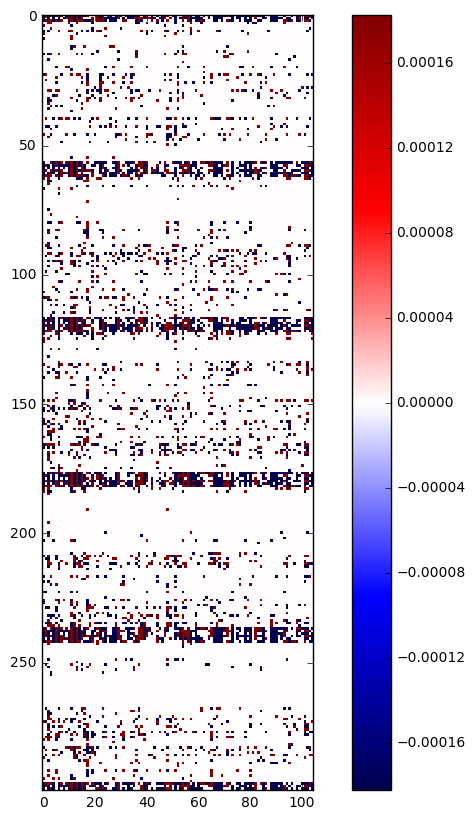

In [30]:
d = res
vmin = max(-d.min(), d.max())/50.
plt.figure(figsize=(10, 10))
plt.imshow(d, cmap = 'seismic' ,interpolation='nearest', vmin=-vmin, vmax=vmin)
plt.colorbar()
plt.show()

In [31]:
TV = 0
for i in range(2, M * p):
    TV += np.linalg.norm((res[:, i] / p2 - res[:, i - 1] / p2), 1)
    
print TV, np.linalg.norm(res / p2, 1)

0.0529971554776 0.00101193051268
